In [ ]:
# ============================================================================
# SEC FILING SENTIMENT ANALYSIS - OPTIMIZED FOR GOOGLE COLAB
# ============================================================================
# Professional-grade sentiment analysis of SEC 10-K filings
# Analyzes MD&A, Risk Factors, and other sections for investor insights
# ============================================================================
# Data input: https://www.kaggle.com/datasets/pranjalverma08/sec-edgar-annual-financial-filings-2021
# ============================================================================
# Professional ML Pipeline for Financial Document Analysis
#
# Pipeline Stages:
# 1. Environment Setup & Configuration
# 2. Data Ingestion & Validation
# 3. Data Preprocessing
# 4. Model Initialization
# 5. Feature Extraction & Transformation
# 6. Inference Pipeline
# 7. Post-Processing & Aggregation
# 8. Evaluation & Visualization
# 9. Reporting & Export
# ============================================================================

In [ ]:
# ============================================================================
# STAGE 1: ENVIRONMENT SETUP & CONFIGURATION
# ============================================================================

print("=" * 70)
print("STAGE 1: ENVIRONMENT SETUP")
print("=" * 70)

import warnings
warnings.filterwarnings('ignore')

# Core imports
from pathlib import Path
from typing import Dict, List, Any, Tuple, Optional, Union
from dataclasses import dataclass, field, asdict
from functools import lru_cache
from collections import Counter
import json
import sys
import logging

# Data science stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Environment detection
try:
    import google.colab
    IN_COLAB = True
    from tqdm.notebook import tqdm
except ImportError:
    IN_COLAB = False
    from tqdm import tqdm

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
if IN_COLAB:
    %matplotlib inline

print(f"✓ Environment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"✓ Python: {sys.version.split()[0]}")
print(f"✓ NumPy: {np.__version__} | Pandas: {pd.__version__}")

STAGE 1: ENVIRONMENT SETUP
✓ Environment: Google Colab
✓ Python: 3.12.12
✓ NumPy: 2.0.2 | Pandas: 2.2.2


In [ ]:
# ============================================================================
# STAGE 1.1: PIPELINE CONFIGURATION
# ============================================================================

@dataclass
class PipelineConfig:
    """
    Centralized configuration for the entire ML pipeline.
    Follows 12-factor app methodology for configuration management.
    """

    # Environment
    base_dir: Path = Path.cwd()
    data_dir: Path = field(init=False)
    output_dir: Path = field(init=False)
    cache_dir: Path = field(init=False)

    # Data ingestion
    file_pattern: str = "*.json"
    sections_of_interest: List[str] = field(default_factory=lambda: ['item_7', 'item_1A'])
    min_text_length: int = 100  # Minimum characters to process

    # Preprocessing
    chunk_size: int = 500  # Characters per chunk
    chunk_overlap: int = 50  # Overlap between chunks
    remove_whitespace: bool = True
    lowercase: bool = False

    # Model configuration
    model_name: str = "ProsusAI/finbert"
    fallback_model: str = "distilbert-base-uncased-finetuned-sst-2-english"
    batch_size: int = 32
    max_length: int = 512

    # Aggregation
    aggregation_method: str = "weighted_average"  # 'majority_vote', 'weighted_average'
    confidence_threshold: float = 0.5

    # Risk assessment thresholds
    risk_optimism_threshold: float = 0.70
    risk_distress_threshold: float = 0.60
    risk_vague_threshold: float = 0.30
    risk_mixed_range: Tuple[float, float] = (0.35, 0.65)

    # Visualization
    color_scheme: Dict[str, str] = field(default_factory=lambda: {
        'positive': '#2ecc71',
        'negative': '#e74c3c',
        'neutral': '#95a5a6',
        'info': '#3498db',
        'warning': '#f39c12'
    })

    # Output
    save_intermediate: bool = True
    export_format: str = "csv"  # 'csv', 'json', 'parquet'

    def __post_init__(self):
        """Initialize derived paths and create directory structure"""
        self.data_dir = self.base_dir / "sec_filings_data"
        self.output_dir = self.base_dir / "output"
        self.cache_dir = self.base_dir / ".cache"

        # Create directories
        for directory in [self.data_dir, self.output_dir, self.cache_dir]:
            directory.mkdir(parents=True, exist_ok=True)

        logger.info(f"Pipeline initialized with {len(self.sections_of_interest)} sections")

    def to_dict(self) -> Dict[str, Any]:
        """Export configuration as dictionary"""
        return asdict(self)

    def save(self, path: Optional[Path] = None) -> None:
        """Save configuration to JSON"""
        path = path or self.output_dir / "pipeline_config.json"
        with open(path, 'w') as f:
            json.dump(self.to_dict(), f, indent=2, default=str)
        logger.info(f"Configuration saved to {path}")

# Initialize global configuration
config = PipelineConfig()
config.save()

print(f"\n✓ Configuration:")
print(f"  Data: {config.data_dir}")
print(f"  Output: {config.output_dir}")
print(f"  Sections: {config.sections_of_interest}")
print(f"  Chunk size: {config.chunk_size}")
print(f"  Model: {config.model_name}")
print("=" * 70)



✓ Configuration:
  Data: /content/sec_filings_data
  Output: /content/output
  Sections: ['item_7', 'item_1A']
  Chunk size: 500
  Model: ProsusAI/finbert


In [ ]:
# ============================================================================
# STAGE 2: DATA INGESTION & VALIDATION
# ============================================================================

print("\nSTAGE 2: DATA INGESTION")
print("=" * 70)

class DataValidator:
    """Validates input data quality and structure"""

    @staticmethod
    def validate_file(path: Path) -> Tuple[bool, str]:
        """Validate single JSON file"""
        if not path.exists():
            return False, "File not found"

        if path.stat().st_size == 0:
            return False, "Empty file"

        try:
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            if not isinstance(data, dict):
                return False, "Invalid JSON structure"

            return True, "Valid"

        except json.JSONDecodeError as e:
            return False, f"JSON decode error: {e}"
        except Exception as e:
            return False, f"Error: {e}"

    @staticmethod
    def validate_text(text: str, min_length: int = 100) -> Tuple[bool, str]:
        """Validate text content"""
        if not text or not text.strip():
            return False, "Empty text"

        if len(text) < min_length:
            return False, f"Text too short ({len(text)} chars)"

        return True, "Valid"

class DataIngestion:
    """Handles data loading with caching and validation"""

    def __init__(self, config: PipelineConfig):
        self.config = config
        self.validator = DataValidator()
        self.cache = {}

    @lru_cache(maxsize=128)
    def load_filing(self, path: str, sections: tuple) -> Dict[str, str]:
        """Load filing data with validation and caching"""
        path = Path(path)

        # Validate file
        is_valid, msg = self.validator.validate_file(path)
        if not is_valid:
            logger.warning(f"File validation failed for {path.name}: {msg}")
            return {}

        # Load data
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Extract sections
        result = {}
        for section in sections:
            if section in data:
                content = data[section]

                # Handle different content types
                if isinstance(content, str):
                    text = content
                elif isinstance(content, dict) and 'text' in content:
                    text = content['text']
                elif isinstance(content, dict):
                    text = json.dumps(content, indent=2)
                else:
                    text = str(content)

                # Validate text
                is_valid, msg = self.validator.validate_text(
                    text,
                    self.config.min_text_length
                )

                if is_valid:
                    result[section] = text
                else:
                    logger.warning(f"Text validation failed for {section}: {msg}")

        return result

    def discover_files(self) -> List[Path]:
        """Discover and validate all data files"""
        files = sorted(self.config.data_dir.glob(self.config.file_pattern))

        valid_files = []
        for file in files:
            is_valid, msg = self.validator.validate_file(file)
            if is_valid:
                valid_files.append(file)
            else:
                logger.warning(f"Skipping {file.name}: {msg}")

        logger.info(f"Discovered {len(valid_files)}/{len(files)} valid files")
        return valid_files

# Initialize ingestion pipeline
ingestion = DataIngestion(config)
available_files = ingestion.discover_files()

print(f"✓ Data ingestion initialized")
print(f"  Files found: {len(available_files)}")
if available_files:
    total_size = sum(f.stat().st_size for f in available_files)
    print(f"  Total size: {total_size / 1024 / 1024:.2f} MB")
print("=" * 70)


STAGE 2: DATA INGESTION
✓ Data ingestion initialized
  Files found: 191
  Total size: 65.83 MB


In [ ]:
# ============================================================================
# STAGE 3: DATA PREPROCESSING
# ============================================================================

print("\nSTAGE 3: DATA PREPROCESSING")
print("=" * 70)

class TextPreprocessor:
    """Handles text preprocessing and chunking"""

    def __init__(self, config: PipelineConfig):
        self.config = config

    def preprocess(self, text: str) -> str:
        """Apply preprocessing transformations"""
        if self.config.remove_whitespace:
            text = ' '.join(text.split())

        if self.config.lowercase:
            text = text.lower()

        return text

    def chunk_text(self, text: str) -> List[Tuple[int, str]]:
        """
        Split text into overlapping chunks for processing.

        Returns:
            List of (chunk_id, chunk_text) tuples
        """
        text = self.preprocess(text)

        if len(text) <= self.config.chunk_size:
            return [(0, text)]

        chunks = []
        start = 0
        chunk_id = 0

        while start < len(text):
            end = start + self.config.chunk_size
            chunk = text[start:end]

            if chunk.strip():
                chunks.append((chunk_id, chunk))
                chunk_id += 1

            # Move start with overlap
            start += self.config.chunk_size - self.config.chunk_overlap

        return chunks

    def get_statistics(self, text: str) -> Dict[str, Any]:
        """Calculate text statistics"""
        return {
            'char_count': len(text),
            'word_count': len(text.split()),
            'line_count': text.count('\n') + 1,
            'avg_word_length': np.mean([len(w) for w in text.split()]) if text.split() else 0
        }

# Initialize preprocessor
preprocessor = TextPreprocessor(config)

print(f"✓ Preprocessor initialized")
print(f"  Chunk size: {config.chunk_size} chars")
print(f"  Overlap: {config.chunk_overlap} chars")
print(f"  Whitespace removal: {config.remove_whitespace}")
print("=" * 70)


STAGE 3: DATA PREPROCESSING
✓ Preprocessor initialized
  Chunk size: 500 chars
  Overlap: 50 chars
  Whitespace removal: True


In [ ]:
# ============================================================================
# STAGE 4: MODEL INITIALIZATION
# ============================================================================

print("\nSTAGE 4: MODEL INITIALIZATION")
print("=" * 70)

try:
    import transformers
except ImportError:
    print("Installing transformers...")
    !pip install -q transformers torch
    import transformers

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

class SentimentModel:
    """
    Sentiment analysis model wrapper.
    Handles model loading, inference, and error recovery.
    """

    def __init__(self, config: PipelineConfig):
        self.config = config
        self.device = 0 if torch.cuda.is_available() else -1
        self.model_name = None
        self.pipeline = None

        self._initialize_model()

    def _initialize_model(self):
        """Initialize model with fallback"""
        try:
            logger.info(f"Loading {self.config.model_name}...")
            self.pipeline = pipeline(
                "sentiment-analysis",
                model=self.config.model_name,
                device=self.device,
                truncation=True,
                max_length=self.config.max_length
            )
            self.model_name = self.config.model_name
            logger.info(f"✓ Loaded {self.model_name}")

        except Exception as e:
            logger.warning(f"Failed to load {self.config.model_name}: {e}")
            logger.info(f"Falling back to {self.config.fallback_model}")

            self.pipeline = pipeline(
                "sentiment-analysis",
                model=self.config.fallback_model,
                device=self.device,
                truncation=True,
                max_length=self.config.max_length
            )
            self.model_name = self.config.fallback_model

    def predict(self, texts: Union[str, List[str]]) -> List[Dict[str, Any]]:
        """
        Run inference on text(s).

        Args:
            texts: Single text or list of texts

        Returns:
            List of prediction dictionaries
        """
        if isinstance(texts, str):
            texts = [texts]

        try:
            results = self.pipeline(texts)
            return self._normalize_predictions(results)
        except Exception as e:
            logger.error(f"Prediction error: {e}")
            return [{'label': 'Neutral', 'score': 0.5} for _ in texts]

    @staticmethod
    def _normalize_predictions(predictions: List[Dict]) -> List[Dict[str, Any]]:
        """Normalize model outputs to consistent format"""
        normalized = []
        for pred in predictions:
            label = pred['label'].upper()

            if 'POS' in label:
                label = 'Positive'
            elif 'NEG' in label:
                label = 'Negative'
            else:
                label = 'Neutral'

            normalized.append({
                'label': label,
                'score': float(pred['score'])
            })

        return normalized

    def health_check(self) -> bool:
        """Verify model is working"""
        try:
            result = self.predict("This is a test.")
            return len(result) > 0 and 'label' in result[0]
        except:
            return False

# Initialize model
model = SentimentModel(config)

print(f"✓ Model: {model.model_name}")
print(f"✓ Device: {'GPU' if model.device == 0 else 'CPU'}")
print(f"✓ Health check: {'PASS' if model.health_check() else 'FAIL'}")

# Model validation with diverse examples
print(f"\n🧪 Model Validation:")
test_cases = [
    ("The company reported strong revenue growth.", "Expected: Positive"),
    ("The company faces significant financial risks.", "Expected: Negative"),
    ("The company continues normal operations.", "Expected: Neutral")
]

for text, expected in test_cases:
    result = model.predict(text)[0]
    print(f"  {result['label']:10s} ({result['score']:.2f}) | {expected}")

print("=" * 70)



STAGE 4: MODEL INITIALIZATION


Device set to use cuda:0


✓ Model: ProsusAI/finbert
✓ Device: GPU
✓ Health check: PASS

🧪 Model Validation:
  Positive   (0.95) | Expected: Positive
  Negative   (0.73) | Expected: Negative
  Neutral    (0.83) | Expected: Neutral


In [ ]:
# ============================================================================
# STAGE 5: FEATURE EXTRACTION & TRANSFORMATION
# ============================================================================

print("\nSTAGE 5: FEATURE EXTRACTION")
print("=" * 70)

class FeatureExtractor:
    """Extract features from text for sentiment analysis"""

    def __init__(self, config: PipelineConfig, preprocessor: TextPreprocessor, model: SentimentModel):
        self.config = config
        self.preprocessor = preprocessor
        self.model = model

    def extract(self, text: str) -> Dict[str, Any]:
        """
        Extract features from text including:
        - Text statistics
        - Chunk-level sentiments
        - Raw predictions
        """
        # Get text statistics
        stats = self.preprocessor.get_statistics(text)

        # Chunk text
        chunks = self.preprocessor.chunk_text(text)

        # Get predictions for all chunks (batch)
        chunk_texts = [chunk_text for _, chunk_text in chunks]
        predictions = self.model.predict(chunk_texts)

        # Combine chunks with predictions
        chunk_features = [
            {
                'chunk_id': chunk_id,
                'text': chunk_text,
                'label': pred['label'],
                'score': pred['score']
            }
            for (chunk_id, chunk_text), pred in zip(chunks, predictions)
        ]

        return {
            'statistics': stats,
            'chunks': chunk_features,
            'num_chunks': len(chunk_features)
        }

# Initialize feature extractor
feature_extractor = FeatureExtractor(config, preprocessor, model)

print(f"✓ Feature extractor initialized")
print(f"  Features: text_stats, chunk_sentiments")
print("=" * 70)



STAGE 5: FEATURE EXTRACTION
✓ Feature extractor initialized
  Features: text_stats, chunk_sentiments


In [ ]:
# ============================================================================
# STAGE 6: INFERENCE PIPELINE
# ============================================================================

print("\nSTAGE 6: INFERENCE PIPELINE")
print("=" * 70)

class InferencePipeline:
    """End-to-end inference pipeline"""

    def __init__(self, config: PipelineConfig, feature_extractor: FeatureExtractor):
        self.config = config
        self.feature_extractor = feature_extractor

    def predict_single(self, text: str) -> Dict[str, Any]:
        """Run inference on single text"""
        features = self.feature_extractor.extract(text)
        return features

    def predict_batch(self, texts: Dict[str, str]) -> Dict[str, Dict[str, Any]]:
        """Run inference on multiple texts"""
        results = {}
        for key, text in texts.items():
            results[key] = self.predict_single(text)
        return results

# Initialize inference pipeline
inference = InferencePipeline(config, feature_extractor)

print(f"✓ Inference pipeline ready")
print("=" * 70)



STAGE 6: INFERENCE PIPELINE
✓ Inference pipeline ready


In [ ]:
# ============================================================================
# STAGE 7: POST-PROCESSING & AGGREGATION
# ============================================================================

print("\nSTAGE 7: POST-PROCESSING")
print("=" * 70)

class ResultAggregator:
    """Aggregate chunk-level predictions to document-level"""

    def __init__(self, config: PipelineConfig):
        self.config = config

    def aggregate(self, features: Dict[str, Any]) -> Dict[str, Any]:
        """
        Aggregate chunk-level predictions.

        Supports multiple aggregation methods:
        - majority_vote: Most common label
        - weighted_average: Average weighted by confidence scores
        """
        chunks = features['chunks']

        if not chunks:
            return self._empty_result()

        # Extract labels and scores
        labels = np.array([c['label'] for c in chunks])
        scores = np.array([c['score'] for c in chunks])

        # Calculate sentiment distribution
        label_counts = Counter(labels)
        total = len(labels)

        pos_ratio = label_counts.get('Positive', 0) / total
        neg_ratio = label_counts.get('Negative', 0) / total
        neu_ratio = label_counts.get('Neutral', 0) / total

        # Calculate signed scores
        signed_scores = np.array([
            score if label == 'Positive' else -score if label == 'Negative' else 0
            for label, score in zip(labels, scores)
        ])

        # Aggregate based on method
        if self.config.aggregation_method == 'majority_vote':
            overall_label = label_counts.most_common(1)[0][0]
            confidence = label_counts[overall_label] / total
        else:  # weighted_average
            avg_score = signed_scores.mean()
            if pos_ratio > neg_ratio and pos_ratio > neu_ratio:
                overall_label = 'Positive'
            elif neg_ratio > pos_ratio and neg_ratio > neu_ratio:
                overall_label = 'Negative'
            else:
                overall_label = 'Neutral'
            confidence = max(pos_ratio, neg_ratio, neu_ratio)

        return {
            'label': overall_label,
            'score': float(signed_scores.mean()),
            'confidence': float(confidence),
            'pos_ratio': float(pos_ratio),
            'neg_ratio': float(neg_ratio),
            'neu_ratio': float(neu_ratio),
            'distribution': dict(label_counts),
            'num_chunks': total,
            'statistics': features['statistics']
        }

    @staticmethod
    def _empty_result() -> Dict[str, Any]:
        """Return empty result"""
        return {
            'label': 'Neutral',
            'score': 0.0,
            'confidence': 0.0,
            'pos_ratio': 0.0,
            'neg_ratio': 0.0,
            'neu_ratio': 0.0,
            'distribution': {},
            'num_chunks': 0,
            'statistics': {}
        }

# Initialize aggregator
aggregator = ResultAggregator(config)

print(f"✓ Aggregator initialized")
print(f"  Method: {config.aggregation_method}")
print(f"  Confidence threshold: {config.confidence_threshold}")
print("=" * 70)


STAGE 7: POST-PROCESSING
✓ Aggregator initialized
  Method: weighted_average
  Confidence threshold: 0.5


In [ ]:
# ============================================================================
# STAGE 8: RISK ASSESSMENT MODULE
# ============================================================================

print("\nSTAGE 8: RISK ASSESSMENT")
print("=" * 70)

class RiskAssessor:
    """Assess business risks from sentiment analysis"""

    def __init__(self, config: PipelineConfig):
        self.config = config

    def assess(self, sentiment: Dict[str, Any]) -> Dict[str, Any]:
        """Assess risk level and specific risks"""
        risks = []
        severity = "LOW"

        pos = sentiment['pos_ratio']
        neg = sentiment['neg_ratio']
        conf = sentiment['confidence']

        # Risk 1: Over-optimism
        if pos > self.config.risk_optimism_threshold:
            risks.append("🔴 OVER-OPTIMISM: Unusually positive tone may mask issues")
            severity = "HIGH"

        # Risk 2: Distress
        if neg > self.config.risk_distress_threshold:
            risks.append("🔴 DISTRESS: High negative sentiment indicates problems")
            severity = "HIGH"

        # Risk 3: Vague language
        if conf < self.config.risk_vague_threshold:
            risks.append("🟠 VAGUE: Low confidence suggests unclear disclosures")
            severity = max(severity, "MEDIUM", key=lambda x: {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2}[x])

        # Risk 4: Mixed signals
        low, high = self.config.risk_mixed_range
        if low < pos < high and low < neg < high:
            risks.append("🟡 MIXED: Conflicting narratives detected")
            severity = max(severity, "MEDIUM", key=lambda x: {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2}[x])

        return {
            'severity': severity,
            'risks': risks or ["✅ LOW RISK: Clear, moderate tone"],
            'confidence': conf,
            'recommendation': self._get_recommendation(severity)
        }

    @staticmethod
    def _get_recommendation(severity: str) -> str:
        """Get recommendation based on severity"""
        recommendations = {
            'HIGH': "Conduct thorough audit of disclosure statements",
            'MEDIUM': "Review specific flagged sections in detail",
            'LOW': "Standard review procedures are sufficient"
        }
        return recommendations.get(severity, recommendations['LOW'])

# Initialize risk assessor
risk_assessor = RiskAssessor(config)

print(f"✓ Risk assessor initialized")
print(f"  Thresholds: Optimism={config.risk_optimism_threshold}, "
      f"Distress={config.risk_distress_threshold}")
print("=" * 70)



STAGE 8: RISK ASSESSMENT
✓ Risk assessor initialized
  Thresholds: Optimism=0.7, Distress=0.6


In [ ]:
# ============================================================================
# STAGE 9: VISUALIZATION ENGINE
# ============================================================================

print("\nSTAGE 9: VISUALIZATION")
print("=" * 70)

class VisualizationEngine:
    """Generate optimized visualizations for analysis results"""

    def __init__(self, config: PipelineConfig):
        self.config = config
        self.colors = config.color_scheme

    def plot_single_filing_analysis(self, filing_results: Dict[str, Any], file_name: str = ""):
        """
        Four key visualizations for single filing analysis

        Includes:
        1. Section sentiment comparison
        2. Chunk sentiment distribution
        3. Chunk score distribution
        4. Sentiment confidence heatmap
        """
        if not filing_results:
            logger.warning("No filing results to visualize")
            return

        # Collect data for visualization
        section_data = []
        all_chunks = []

        for section, section_data_dict in filing_results.items():
            sentiment = section_data_dict.get('sentiment', {})
            chunks = section_data_dict.get('features', {}).get('chunks', [])

            # Section-level data
            section_data.append({
                'section': section.replace('item_', 'Item ').upper(),
                'sentiment_label': sentiment.get('label', 'Neutral'),
                'score': sentiment.get('score', 0.0),
                'confidence': sentiment.get('confidence', 0.0),
                'num_chunks': sentiment.get('num_chunks', 0)
            })

            # Collect all chunks
            for chunk in chunks:
                all_chunks.append({
                    'section': section.replace('item_', 'Item ').upper(),
                    'label': chunk['label'],
                    'score': chunk['score'],
                    'chunk_id': chunk['chunk_id']
                })

        if not section_data:
            logger.warning("No section data available")
            return

        # Create visualizations
        fig = plt.figure(figsize=(16, 10))

        # 1. Section Sentiment Comparison
        ax1 = plt.subplot(2, 2, 1)
        self._plot_section_comparison(ax1, section_data)

        # 2. Chunk Sentiment Distribution
        ax2 = plt.subplot(2, 2, 2)
        self._plot_chunk_sentiment_distribution(ax2, all_chunks)

        # 3. Chunk Score Distribution (REQUIRED)
        ax3 = plt.subplot(2, 2, 3)
        self._plot_chunk_score_distribution(ax3, all_chunks)

        # 4. Sentiment Confidence Heatmap
        ax4 = plt.subplot(2, 2, 4)
        self._plot_sentiment_confidence_heatmap(ax4, section_data)

        # Title
        if file_name:
            plt.suptitle(f'Filing Analysis: {file_name}', fontsize=16, fontweight='bold', y=1.02)
        else:
            plt.suptitle('Filing Analysis Summary', fontsize=16, fontweight='bold', y=1.02)

        plt.tight_layout()
        plt.show()

        # Print key statistics
        self._print_summary_statistics(section_data, all_chunks)

    def plot_batch_analysis(self, batch_df: pd.DataFrame, chunk_df: pd.DataFrame = None):
        """
        Four key visualizations for batch analysis

        Includes:
        1. Cross-section sentiment overview
        2. Chunk sentiment distribution
        3. Chunk score distribution
        4. Company sentiment comparison
        """
        if batch_df.empty:
            logger.warning("No batch data to visualize")
            return

        fig = plt.figure(figsize=(16, 10))

        # 1. Cross-section Sentiment Overview
        ax1 = plt.subplot(2, 2, 1)
        self._plot_cross_section_overview(ax1, batch_df)

        # 2. Chunk Sentiment Distribution
        ax2 = plt.subplot(2, 2, 2)
        if chunk_df is not None and not chunk_df.empty:
            self._plot_batch_chunk_distribution(ax2, chunk_df)
        else:
            self._plot_estimated_chunk_distribution(ax2, batch_df)

        # 3. Chunk Score Distribution (REQUIRED)
        ax3 = plt.subplot(2, 2, 3)
        if chunk_df is not None and not chunk_df.empty:
            self._plot_batch_score_distribution(ax3, chunk_df)
        else:
            ax3.text(0.5, 0.5, 'Chunk score data unavailable\nRun analysis with chunk details enabled',
                    ha='center', va='center', fontsize=12, transform=ax3.transAxes)
            ax3.set_title('Chunk Score Distribution', fontweight='bold', fontsize=13)
            ax3.axis('off')

        # 4. Company Sentiment Comparison
        ax4 = plt.subplot(2, 2, 4)
        self._plot_company_comparison(ax4, batch_df)

        plt.suptitle(f'Batch Analysis ({len(batch_df["company"].unique())} companies)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        # Print batch statistics
        self._print_batch_statistics(batch_df, chunk_df)

    # HELPER METHODS

    def _plot_section_comparison(self, ax, section_data):
        """Plot sentiment scores and confidence by section"""
        sections = [d['section'] for d in section_data]
        scores = [d['score'] for d in section_data]
        confidences = [d['confidence'] for d in section_data]

        # Colors based on sentiment
        colors = []
        for d in section_data:
            score = d['score']
            if score > 0.1:
                colors.append(self.colors['positive'])
            elif score < -0.1:
                colors.append(self.colors['negative'])
            else:
                colors.append(self.colors['neutral'])

        # Create bars
        x = np.arange(len(sections))
        width = 0.35

        bars1 = ax.bar(x - width/2, scores, width, label='Score',
                      color=colors, alpha=0.8, edgecolor='white')
        bars2 = ax.bar(x + width/2, confidences, width, label='Confidence',
                      color=self.colors['info'], alpha=0.8, edgecolor='white')

        ax.axhline(y=0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
        ax.set_xlabel('Section', fontsize=11)
        ax.set_ylabel('Score / Confidence', fontsize=11)
        ax.set_title('Section Sentiment Comparison', fontweight='bold', fontsize=13)
        ax.set_xticks(x)
        ax.set_xticklabels(sections, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        # Add value labels
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:.2f}', ha='center', va='bottom' if height >= 0 else 'top',
                   fontsize=9)

    def _plot_chunk_sentiment_distribution(self, ax, all_chunks):
        """Plot distribution of sentiment labels across chunks"""
        if not all_chunks:
            ax.text(0.5, 0.5, 'No chunk data available',
                   ha='center', va='center', fontsize=12, transform=ax.transAxes)
            ax.set_title('Chunk Sentiment Distribution', fontweight='bold', fontsize=13)
            ax.axis('off')
            return

        # Count sentiment labels
        labels = [chunk['label'] for chunk in all_chunks]
        label_counts = Counter(labels)

        # Ensure all labels are present
        for label in ['Positive', 'Neutral', 'Negative']:
            if label not in label_counts:
                label_counts[label] = 0

        # Sort labels
        sorted_labels = ['Negative', 'Neutral', 'Positive']
        counts = [label_counts[label] for label in sorted_labels]
        colors = [self.colors[label.lower()] for label in sorted_labels]

        # Create bar chart
        bars = ax.bar(sorted_labels, counts, color=colors, alpha=0.8, edgecolor='white', width=0.6)
        ax.set_xlabel('Sentiment Label', fontsize=11)
        ax.set_ylabel('Number of Chunks', fontsize=11)
        ax.set_title('Chunk Sentiment Distribution', fontweight='bold', fontsize=13)
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        # Add count labels and percentages
        total = sum(counts)
        for bar, count, label in zip(bars, counts, sorted_labels):
            height = bar.get_height()
            percentage = (count / total * 100) if total > 0 else 0
            ax.text(bar.get_x() + bar.get_width()/2, height + max(counts)*0.02,
                   f'{count}\n({percentage:.1f}%)', ha='center', va='bottom',
                   fontsize=10)

        # Add total count
        ax.text(0.5, 0.95, f'Total Chunks: {total}',
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))

    def _plot_chunk_score_distribution(self, ax, all_chunks):
        """Plot distribution of sentiment scores across chunks"""
        if not all_chunks:
            ax.text(0.5, 0.5, 'No chunk data available',
                   ha='center', va='center', fontsize=12, transform=ax.transAxes)
            ax.set_title('Chunk Score Distribution', fontweight='bold', fontsize=13)
            ax.axis('off')
            return

        # Extract scores
        scores = [chunk['score'] for chunk in all_chunks]
        labels = [chunk['label'] for chunk in all_chunks]

        # Create histogram with density curve
        n, bins, patches = ax.hist(scores, bins=30, alpha=0.7,
                                  color=self.colors['info'], edgecolor='white', density=True)

        # Add KDE curve
        from scipy.stats import gaussian_kde
        try:
            kde = gaussian_kde(scores)
            x = np.linspace(min(scores), max(scores), 100)
            ax.plot(x, kde(x), color=self.colors['warning'], linewidth=2, label='Density')
        except:
            pass

        # Add vertical lines for key statistics
        mean_score = np.mean(scores)
        median_score = np.median(scores)

        ax.axvline(x=mean_score, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_score:.3f}')
        ax.axvline(x=median_score, color='green', linestyle=':', linewidth=2,
                  label=f'Median: {median_score:.3f}')
        ax.axvline(x=0, color='black', linewidth=1, alpha=0.5)

        # Calculate and display statistics
        pos_count = sum(1 for s in scores if s > 0.1)
        neg_count = sum(1 for s in scores if s < -0.1)
        neu_count = len(scores) - pos_count - neg_count

        stats_text = (f'Total: {len(scores)} chunks\n'
                     f'Positive: {pos_count} ({pos_count/len(scores)*100:.1f}%)\n'
                     f'Neutral: {neu_count} ({neu_count/len(scores)*100:.1f}%)\n'
                     f'Negative: {neg_count} ({neg_count/len(scores)*100:.1f}%)')

        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
               ha='right', va='top', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_xlabel('Sentiment Score', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title('Chunk Score Distribution', fontweight='bold', fontsize=13)
        ax.legend(loc='upper left', fontsize=9)
        ax.grid(alpha=0.3, linestyle='--')

    def _plot_sentiment_confidence_heatmap(self, ax, section_data):
        """Plot heatmap of sentiment vs confidence"""
        if not section_data:
            ax.text(0.5, 0.5, 'No section data available',
                   ha='center', va='center', fontsize=12, transform=ax.transAxes)
            ax.set_title('Sentiment Confidence Matrix', fontweight='bold', fontsize=13)
            ax.axis('off')
            return

        # Prepare data for heatmap
        sections = [d['section'] for d in section_data]
        scores = [d['score'] for d in section_data]
        confidences = [d['confidence'] for d in section_data]

        # Create scatter plot with color coding
        scatter = ax.scatter(scores, confidences, s=200, alpha=0.7,
                           c=[self._get_sentiment_color(score) for score in scores],
                           edgecolors='white', linewidth=1.5)

        # Add section labels
        for i, (section, score, conf) in enumerate(zip(sections, scores, confidences)):
            ax.annotate(section, (score, conf), fontsize=9,
                       xytext=(5, 5), textcoords='offset points')

        # Add decision boundaries
        ax.axvline(x=0.1, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=-0.1, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=0.7, color='gray', linestyle=':', alpha=0.5, label='High Confidence')
        ax.axhline(y=0.3, color='gray', linestyle=':', alpha=0.5, label='Low Confidence')

        # Add quadrants
        ax.text(0.3, 0.8, 'Strong Positive', transform=ax.transAxes,
               ha='center', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor=self.colors['positive'], alpha=0.2))
        ax.text(0.7, 0.8, 'Weak Positive', transform=ax.transAxes,
               ha='center', va='center', fontsize=10,
               bbox=dict(boxstyle='round', facecolor=self.colors['positive'], alpha=0.1))
        ax.text(0.3, 0.2, 'Strong Negative', transform=ax.transAxes,
               ha='center', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor=self.colors['negative'], alpha=0.2))
        ax.text(0.7, 0.2, 'Weak Negative', transform=ax.transAxes,
               ha='center', va='center', fontsize=10,
               bbox=dict(boxstyle='round', facecolor=self.colors['negative'], alpha=0.1))

        ax.set_xlabel('Sentiment Score', fontsize=11)
        ax.set_ylabel('Confidence', fontsize=11)
        ax.set_title('Sentiment-Confidence Matrix', fontweight='bold', fontsize=13)
        ax.set_xlim([-1, 1])
        ax.set_ylim([0, 1])
        ax.grid(alpha=0.3, linestyle='--')
        ax.legend(loc='lower left', fontsize=9)

    def _plot_cross_section_overview(self, ax, batch_df):
        """Plot stacked sentiment distribution across sections"""
        # Create pivot table
        pivot = batch_df.pivot_table(
            index='section',
            columns='sentiment',
            values='company',
            aggfunc='count',
            fill_value=0
        )
        pivot = pivot.reindex(columns=['Negative', 'Neutral', 'Positive'], fill_value=0)

        colors = [self.colors[c.lower()] for c in pivot.columns]
        pivot.plot(kind='bar', stacked=True, color=colors, ax=ax,
                  alpha=0.8, edgecolor='white', width=0.7)

        ax.set_title('Sentiment Distribution by Section', fontweight='bold', fontsize=13)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_xlabel('Section', fontsize=11)
        ax.legend(title='Sentiment', frameon=True, fontsize=9)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        # Add total count on top of each bar
        for i, (idx, row) in enumerate(pivot.iterrows()):
            total = row.sum()
            ax.text(i, total + 0.5, str(total), ha='center', va='bottom', fontsize=9)

    def _plot_batch_chunk_distribution(self, ax, chunk_df):
        """Plot chunk sentiment distribution for batch"""
        sentiment_counts = chunk_df['label'].value_counts()
        for label in ['Positive', 'Neutral', 'Negative']:
            if label not in sentiment_counts:
                sentiment_counts[label] = 0

        sorted_labels = ['Negative', 'Neutral', 'Positive']
        counts = [sentiment_counts[label] for label in sorted_labels]
        colors = [self.colors[label.lower()] for label in sorted_labels]

        bars = ax.bar(sorted_labels, counts, color=colors, alpha=0.8, edgecolor='white', width=0.6)
        ax.set_xlabel('Sentiment Label', fontsize=11)
        ax.set_ylabel('Number of Chunks', fontsize=11)
        ax.set_title('Batch Chunk Sentiment Distribution', fontweight='bold', fontsize=13)
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        total = sum(counts)
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            percentage = (count / total * 100) if total > 0 else 0
            ax.text(bar.get_x() + bar.get_width()/2, height + max(counts)*0.02,
                   f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

        ax.text(0.5, 0.95, f'Total Chunks: {total}',
               transform=ax.transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))

    def _plot_estimated_chunk_distribution(self, ax, batch_df):
        """Estimate chunk distribution from aggregated data"""
        if 'chunks' not in batch_df.columns or 'pos_ratio' not in batch_df.columns:
            ax.text(0.5, 0.5, 'Chunk data unavailable', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Chunk Distribution', fontweight='bold')
            ax.axis('off')
            return

        total_chunks = batch_df['chunks'].sum()
        pos_chunks = int((batch_df['pos_ratio'] * batch_df['chunks']).sum())
        neg_chunks = int((batch_df['neg_ratio'] * batch_df['chunks']).sum())
        neu_chunks = total_chunks - pos_chunks - neg_chunks

        labels = ['Negative', 'Neutral', 'Positive']
        values = [neg_chunks, neu_chunks, pos_chunks]
        colors = [self.colors[label.lower()] for label in labels]

        bars = ax.bar(labels, values, color=colors, alpha=0.8, edgecolor='white', width=0.6)
        ax.set_title('Estimated Chunk Distribution', fontweight='bold', fontsize=13)
        ax.set_ylabel('Number of Chunks', fontsize=11)
        ax.grid(axis='y', alpha=0.3, linestyle='--')

        for bar, value in zip(bars, values):
            height = bar.get_height()
            percentage = (value / total_chunks * 100) if total_chunks > 0 else 0
            ax.text(bar.get_x() + bar.get_width()/2, height + max(values)*0.02,
                   f'{value}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

    def _plot_batch_score_distribution(self, ax, chunk_df):
        """Plot score distribution for batch chunks"""
        scores = chunk_df['score'].values

        n, bins, patches = ax.hist(scores, bins=30, alpha=0.7,
                                  color=self.colors['info'], edgecolor='white', density=True)

        # Add KDE
        from scipy.stats import gaussian_kde
        try:
            kde = gaussian_kde(scores)
            x = np.linspace(min(scores), max(scores), 100)
            ax.plot(x, kde(x), color=self.colors['warning'], linewidth=2, label='Density')
        except:
            pass

        # Add statistics
        mean_score = np.mean(scores)
        median_score = np.median(scores)

        ax.axvline(x=mean_score, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_score:.3f}')
        ax.axvline(x=median_score, color='green', linestyle=':', linewidth=2,
                  label=f'Median: {median_score:.3f}')
        ax.axvline(x=0, color='black', linewidth=1, alpha=0.5)

        ax.set_xlabel('Sentiment Score', fontsize=11)
        ax.set_ylabel('Density', fontsize=11)
        ax.set_title('Batch Chunk Score Distribution', fontweight='bold', fontsize=13)
        ax.legend(loc='upper left', fontsize=9)
        ax.grid(alpha=0.3, linestyle='--')

        # Add statistics box
        stats_text = (f'Mean: {mean_score:.3f}\n'
                     f'Median: {median_score:.3f}\n'
                     f'Std: {np.std(scores):.3f}\n'
                     f'Range: [{min(scores):.3f}, {max(scores):.3f}]')

        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
               ha='right', va='top', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    def _plot_company_comparison(self, ax, batch_df):
        """Plot average sentiment by company"""
        company_scores = batch_df.groupby('company')['score'].mean().sort_values()

        colors = []
        for score in company_scores.values:
            if score > 0.1:
                colors.append(self.colors['positive'])
            elif score < -0.1:
                colors.append(self.colors['negative'])
            else:
                colors.append(self.colors['neutral'])

        bars = ax.barh(range(len(company_scores)), company_scores.values,
                      color=colors, alpha=0.8, edgecolor='white')

        ax.set_yticks(range(len(company_scores)))
        ax.set_yticklabels(company_scores.index, fontsize=9)
        ax.set_xlabel('Average Sentiment Score', fontsize=11)
        ax.set_title('Company Sentiment Comparison', fontweight='bold', fontsize=13)
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax.grid(axis='x', alpha=0.3, linestyle='--')

        # Add value labels
        for bar, score in zip(bars, company_scores.values):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{score:.3f}', ha='left' if width >= 0 else 'right',
                   va='center', fontsize=8)

    def _get_sentiment_color(self, score):
        """Get color based on sentiment score"""
        if score > 0.1:
            return self.colors['positive']
        elif score < -0.1:
            return self.colors['negative']
        else:
            return self.colors['neutral']

    def _print_summary_statistics(self, section_data, all_chunks):
        """Print summary statistics for single filing"""
        print("\n" + "=" * 70)
        print("ANALYSIS SUMMARY")
        print("=" * 70)

        # Section statistics
        print(f"\n📊 Section Analysis ({len(section_data)} sections):")
        for section in section_data:
            print(f"  {section['section']}:")
            print(f"    Sentiment: {section['sentiment_label']} (Score: {section['score']:.3f})")
            print(f"    Confidence: {section['confidence']:.1%}")
            print(f"    Chunks: {section['num_chunks']}")

        # Chunk statistics
        if all_chunks:
            scores = [chunk['score'] for chunk in all_chunks]
            labels = [chunk['label'] for chunk in all_chunks]

            print(f"\n📈 Chunk-level Statistics ({len(all_chunks)} chunks):")
            print(f"  Average Score: {np.mean(scores):.3f}")
            print(f"  Score Range: [{min(scores):.3f}, {max(scores):.3f}]")
            print(f"  Standard Deviation: {np.std(scores):.3f}")

            label_counts = Counter(labels)
            for label in ['Positive', 'Neutral', 'Negative']:
                count = label_counts.get(label, 0)
                percentage = (count / len(all_chunks)) * 100 if all_chunks else 0
                print(f"  {label}: {count} chunks ({percentage:.1f}%)")

    def _print_batch_statistics(self, batch_df, chunk_df):
        """Print summary statistics for batch analysis"""
        print("\n" + "=" * 70)
        print("BATCH STATISTICS")
        print("=" * 70)

        companies = batch_df['company'].unique()
        sections = batch_df['section'].unique()

        print(f"\n📊 Overview:")
        print(f"  Companies analyzed: {len(companies)}")
        print(f"  Sections analyzed: {len(sections)}")
        print(f"  Total analyses: {len(batch_df)}")

        # Sentiment distribution
        sentiment_counts = batch_df['sentiment'].value_counts()
        print(f"\n🎯 Sentiment Distribution:")
        for sentiment in ['Positive', 'Neutral', 'Negative']:
            count = sentiment_counts.get(sentiment, 0)
            percentage = (count / len(batch_df)) * 100
            print(f"  {sentiment}: {count} ({percentage:.1f}%)")

        # Score statistics
        print(f"\n📈 Score Statistics:")
        print(f"  Average score: {batch_df['score'].mean():.3f}")
        print(f"  Median score: {batch_df['score'].median():.3f}")
        print(f"  Score range: [{batch_df['score'].min():.3f}, {batch_df['score'].max():.3f}]")

        # Chunk statistics
        if chunk_df is not None and not chunk_df.empty:
            print(f"\n🧱 Chunk-level Statistics:")
            print(f"  Total chunks: {len(chunk_df)}")
            print(f"  Average chunk score: {chunk_df['score'].mean():.3f}")
            print(f"  Unique companies: {chunk_df['company'].nunique()}")
            print(f"  Unique sections: {chunk_df['section'].nunique()}")

# Initialize visualization engine
viz = VisualizationEngine(config)

print(f"✓ Visualization engine initialized")
print(f"✓ Key visualizations:")
print(f"  1. Section sentiment comparison")
print(f"  2. Chunk sentiment distribution")
print(f"  3. Chunk score distribution (required)")
print(f"  4. Sentiment confidence matrix")
print("=" * 70)


STAGE 9: VISUALIZATION
✓ Visualization engine initialized
✓ Key visualizations:
  1. Section sentiment comparison
  2. Chunk sentiment distribution
  3. Chunk score distribution (required)
  4. Sentiment confidence matrix



EXECUTION: SINGLE FILING ANALYSIS
Analyzing: 1001601_10K_2020_0001493152-21-008913.json

Processing sections:

  ITEM_7
    Sentiment: Neutral (score: -0.17)
    Confidence: 71.64%
    Distribution: {np.str_('Positive'): 3, np.str_('Negative'): 16, np.str_('Neutral'): 48}
    Risk: LOW - ✅ LOW RISK: Clear, moderate tone

  ITEM_1A
    Sentiment: Negative (score: -0.38)
    Confidence: 51.64%
    Distribution: {np.str_('Neutral'): 54, np.str_('Negative'): 63, np.str_('Positive'): 5}
    Risk: LOW - ✅ LOW RISK: Clear, moderate tone

VISUALIZATIONS


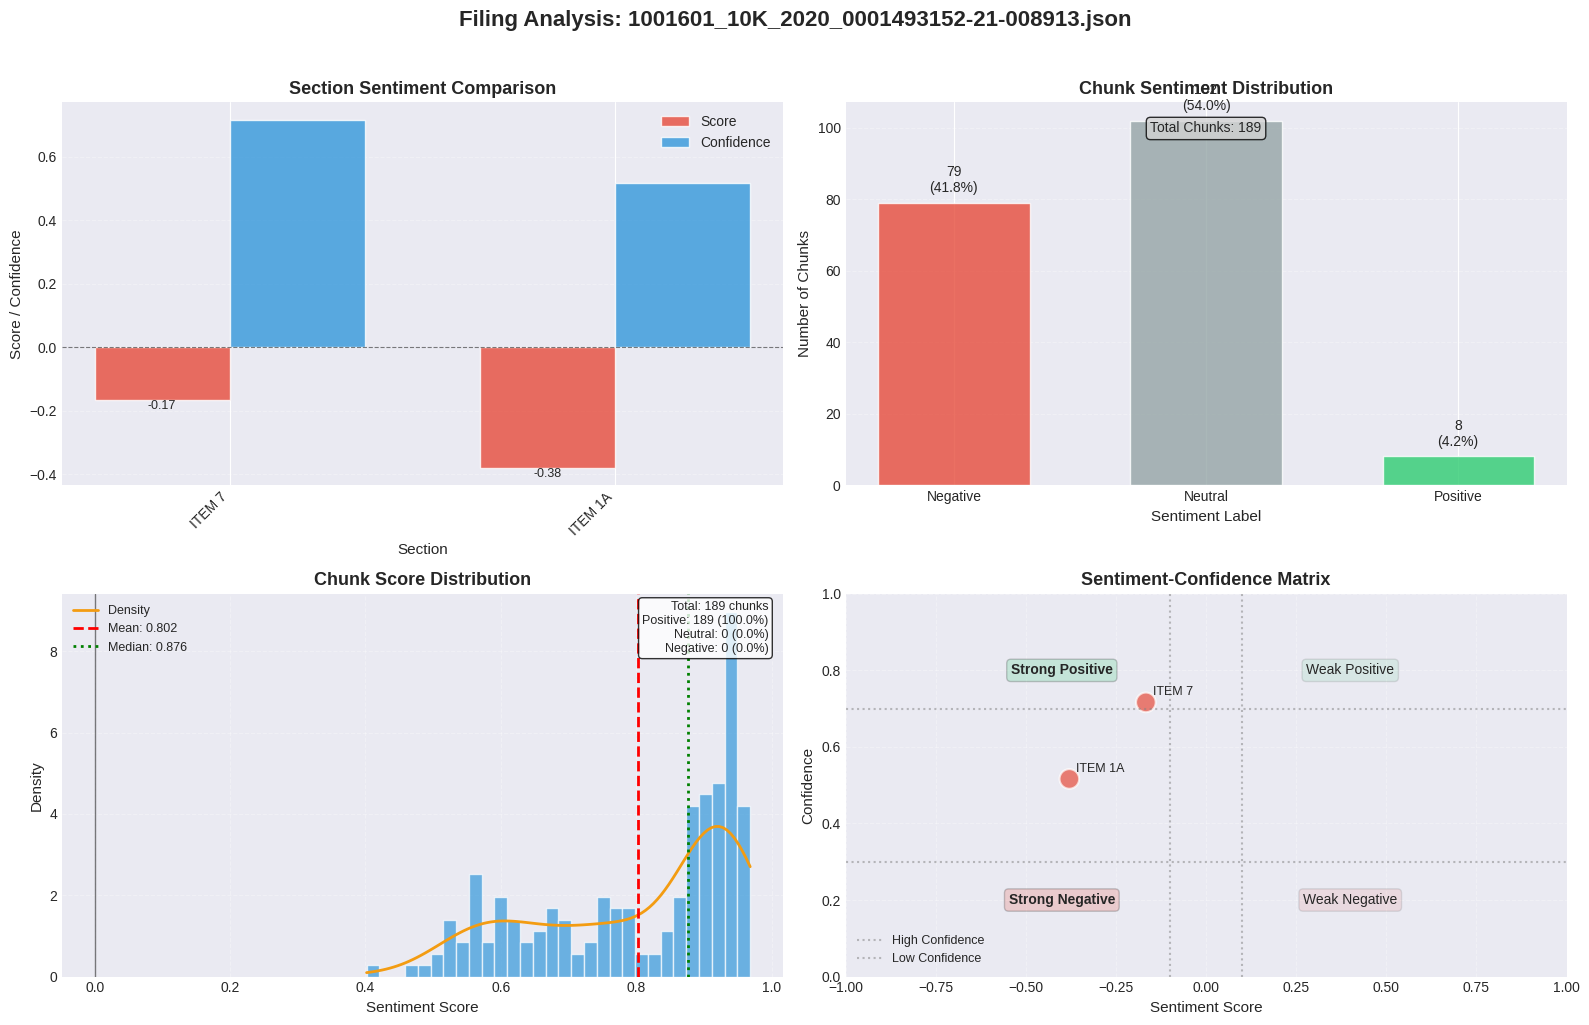


ANALYSIS SUMMARY

📊 Section Analysis (2 sections):
  ITEM 7:
    Sentiment: Neutral (Score: -0.167)
    Confidence: 71.6%
    Chunks: 67
  ITEM 1A:
    Sentiment: Negative (Score: -0.379)
    Confidence: 51.6%
    Chunks: 122

📈 Chunk-level Statistics (189 chunks):
  Average Score: 0.802
  Score Range: [0.402, 0.968]
  Standard Deviation: 0.148
  Positive: 8 chunks (4.2%)
  Neutral: 102 chunks (54.0%)
  Negative: 79 chunks (41.8%)


In [ ]:
# ============================================================================
# STAGE 10: EXECUTION - SINGLE FILING ANALYSIS
# ============================================================================

print("\n" + "=" * 70)
print("EXECUTION: SINGLE FILING ANALYSIS")
print("=" * 70)

if not available_files:
    print("⚠️  No files available for analysis")
    filing_results = {}
else:
    # Load first available file
    selected_file = available_files[0]
    print(f"Analyzing: {selected_file.name}\n")

    filing_data = ingestion.load_filing(str(selected_file), tuple(config.sections_of_interest))

    if not filing_data:
        print("⚠️  No valid sections found")
        filing_results = {}
    else:
        filing_results = {}

        print("Processing sections:")
        for section, text in filing_data.items():
            print(f"\n  {section.upper()}")

            # Run inference
            features = inference.predict_single(text)

            # Aggregate results
            sentiment = aggregator.aggregate(features)

            # Assess risks
            risk = risk_assessor.assess(sentiment)

            # Store results
            filing_results[section] = {
                'sentiment': sentiment,
                'risk': risk,
                'features': features
            }

            # Display summary
            print(f"    Sentiment: {sentiment['label']} (score: {sentiment['score']:+.2f})")
            print(f"    Confidence: {sentiment['confidence']:.2%}")
            print(f"    Distribution: {sentiment['distribution']}")
            print(f"    Risk: {risk['severity']} - {risk['risks'][0]}")

        print(f"\n{('=' * 70)}")
        print("VISUALIZATIONS")
        print("=" * 70)

        # Use the new optimized visualization
        viz.plot_single_filing_analysis(filing_results, selected_file.name)


EXECUTION: BATCH PROCESSING
Found 191 files
Process how many files? (1-191 or 'all'): 5
Processing 5 files...



Analyzing files:   0%|          | 0/5 [00:00<?, ?it/s]


BATCH RESULTS

📋 Company Summary:
        sentiment  score  confidence  chunks
company                                     
1001601  Negative -0.273       0.616     189
1002517  Negative -0.279       0.612     315
1013462  Negative -0.193       0.624     322
1013857  Negative -0.122       0.615     220
1015739  Negative -0.233       0.637     128

✅ Results saved to: /content/output/batch_analysis_20251211_143704.csv
✅ Chunk details saved to: /content/output/chunk_details_20251211_143704.csv

VISUALIZATIONS


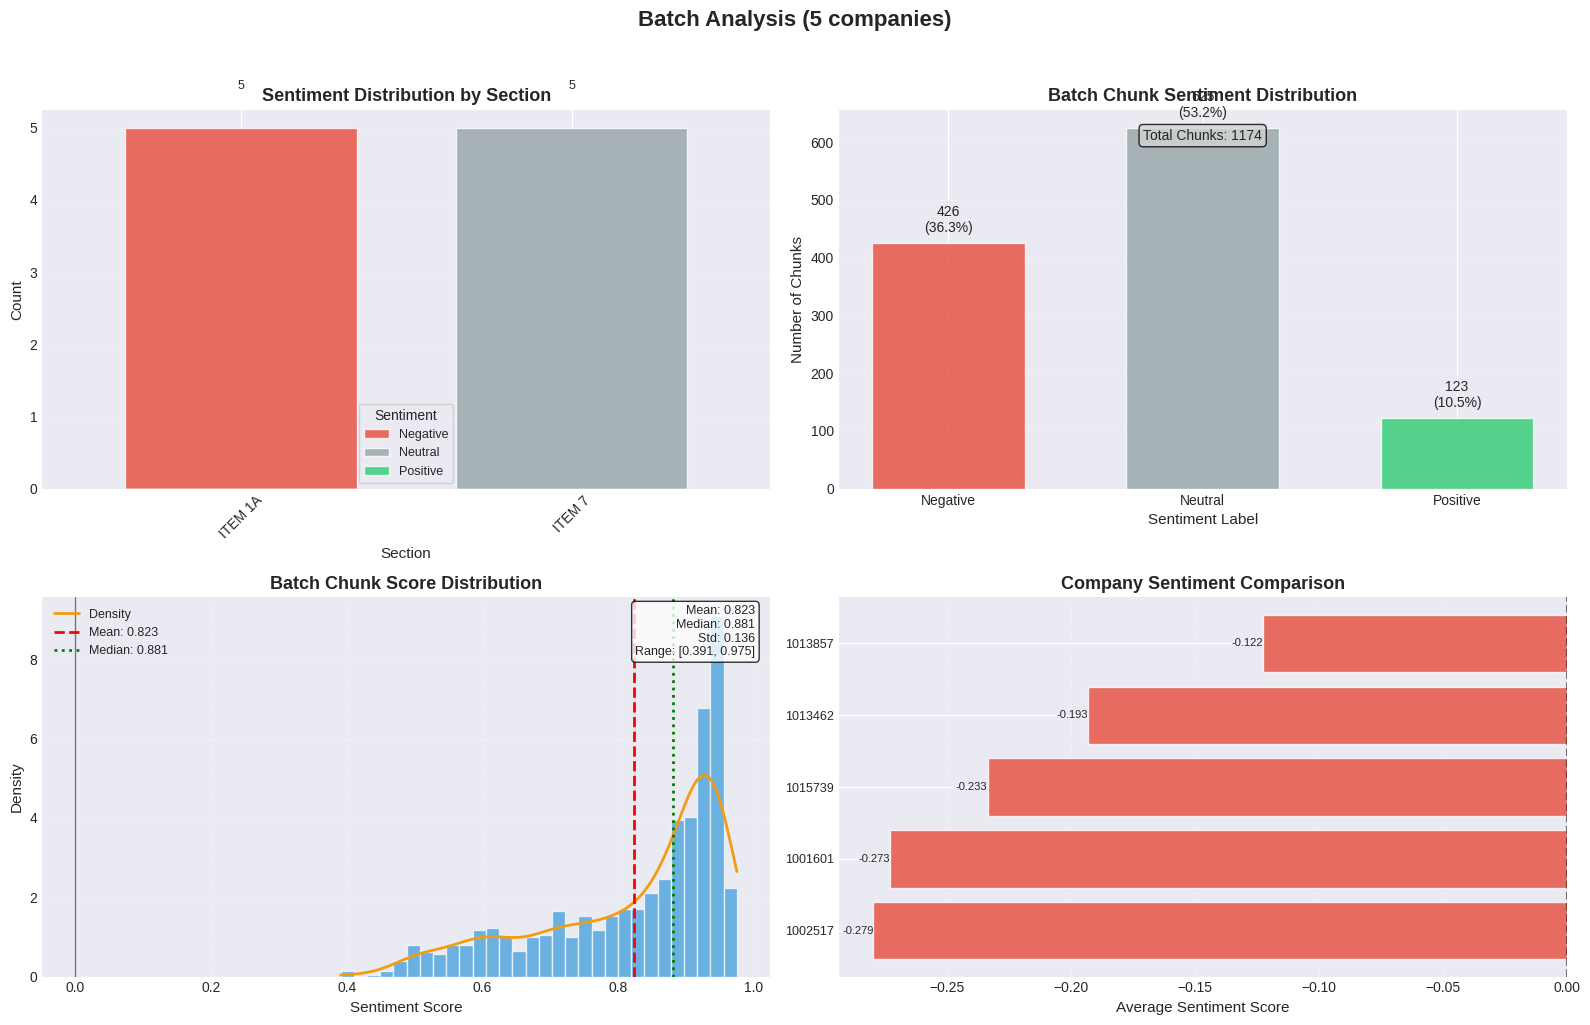


BATCH STATISTICS

📊 Overview:
  Companies analyzed: 5
  Sections analyzed: 2
  Total analyses: 10

🎯 Sentiment Distribution:
  Positive: 0 (0.0%)
  Neutral: 5 (50.0%)
  Negative: 5 (50.0%)

📈 Score Statistics:
  Average score: -0.220
  Median score: -0.241
  Score range: [-0.472, 0.079]

🧱 Chunk-level Statistics:
  Total chunks: 1174
  Average chunk score: 0.823
  Unique companies: 5
  Unique sections: 2

RISK ASSESSMENT


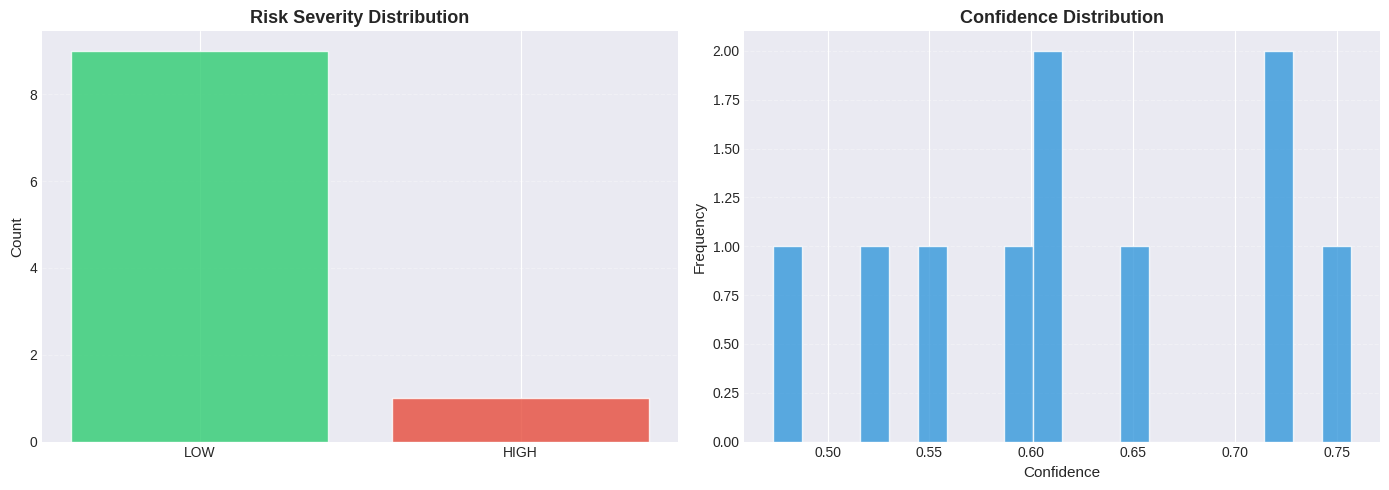


🔍 Risk Assessment Summary:
  High Risk: 1 (10.0%)
  Medium Risk: 0 (0.0%)
  Low Risk: 9 (90.0%)
  Average Confidence: 0.621


In [ ]:
# ============================================================================
# STAGE 11: EXECUTION - BATCH PROCESSING
# ============================================================================

print("\n" + "=" * 70)
print("EXECUTION: BATCH PROCESSING")
print("=" * 70)

if not available_files:
    print("⚠️  No files available")
    batch_results = pd.DataFrame()
else:
    print(f"Found {len(available_files)} files")

    # Ask user how many to process
    user_input = input(f"Process how many files? (1-{len(available_files)} or 'all'): ").strip().lower()

    try:
        num_files = len(available_files) if user_input == 'all' else int(user_input)
        num_files = max(1, min(num_files, len(available_files)))
    except:
        num_files = len(available_files)

    print(f"Processing {num_files} files...\n")

    batch_data = []
    risk_data = []
    detailed_chunk_data = []  # For detailed chunk-level analysis

    for file in tqdm(available_files[:num_files], desc="Analyzing files"):
        try:
            # Load filing
            company_id = file.stem.split('_')[0] if '_' in file.stem else file.stem
            filing_data = ingestion.load_filing(str(file), tuple(config.sections_of_interest))

            # Process each section
            for section, text in filing_data.items():
                features = inference.predict_single(text)
                sentiment = aggregator.aggregate(features)
                risk = risk_assessor.assess(sentiment)

                batch_data.append({
                    'company': company_id,
                    'file': file.name,
                    'section': section.replace('item_', 'Item ').upper(),
                    'sentiment': sentiment['label'],
                    'score': round(sentiment['score'], 3),
                    'confidence': round(sentiment['confidence'], 3),
                    'pos_ratio': round(sentiment['pos_ratio'], 3),
                    'neg_ratio': round(sentiment['neg_ratio'], 3),
                    'neu_ratio': round(sentiment['neu_ratio'], 3),
                    'chunks': sentiment['num_chunks']
                })

                risk_data.append({
                    'company': company_id,
                    'section': section,
                    'severity': risk['severity'],
                    'confidence': risk['confidence']
                })

                # Collect detailed chunk data for visualization
                for chunk in features.get('chunks', []):
                    detailed_chunk_data.append({
                        'company': company_id,
                        'file': file.name,
                        'section': section.replace('item_', 'Item ').upper(),
                        'chunk_id': chunk['chunk_id'],
                        'label': chunk['label'],
                        'score': chunk['score'],
                        'text_preview': chunk['text'][:100] + '...' if len(chunk['text']) > 100 else chunk['text']
                    })

        except Exception as e:
            logger.error(f"Error processing {file.name}: {e}")
            continue

    # Create DataFrames
    batch_results = pd.DataFrame(batch_data)
    risk_summary = pd.DataFrame(risk_data)
    chunk_df = pd.DataFrame(detailed_chunk_data) if detailed_chunk_data else pd.DataFrame()

    if not batch_results.empty:
        print("\n" + "=" * 70)
        print("BATCH RESULTS")
        print("=" * 70)

        # Display summary table
        summary_df = batch_results.groupby('company').agg({
            'sentiment': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Neutral',
            'score': 'mean',
            'confidence': 'mean',
            'chunks': 'sum'
        }).round(3)

        print("\n📋 Company Summary:")
        print(summary_df.to_string())

        # Export results
        output_path = config.output_dir / f"batch_analysis_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.csv"
        batch_results.to_csv(output_path, index=False)
        print(f"\n✅ Results saved to: {output_path}")

        if not chunk_df.empty:
            chunk_output_path = config.output_dir / f"chunk_details_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.csv"
            chunk_df.to_csv(chunk_output_path, index=False)
            print(f"✅ Chunk details saved to: {chunk_output_path}")

        # Visualizations
        print("\n" + "=" * 70)
        print("VISUALIZATIONS")
        print("=" * 70)

        # Use the new optimized batch visualization
        viz.plot_batch_analysis(batch_results, chunk_df)

        # Plot risk dashboard (separate)
        if not risk_summary.empty:
            print("\n" + "=" * 70)
            print("RISK ASSESSMENT")
            print("=" * 70)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

            # Risk severity distribution
            severity_counts = risk_summary['severity'].value_counts()
            severity_colors = {'LOW': config.color_scheme['positive'],
                              'MEDIUM': config.color_scheme['warning'],
                              'HIGH': config.color_scheme['negative']}
            colors = [severity_colors.get(s, config.color_scheme['neutral']) for s in severity_counts.index]

            ax1.bar(severity_counts.index, severity_counts.values, color=colors, alpha=0.8, edgecolor='white')
            ax1.set_title('Risk Severity Distribution', fontweight='bold', fontsize=13)
            ax1.set_ylabel('Count', fontsize=11)
            ax1.grid(axis='y', alpha=0.3, linestyle='--')

            # Confidence distribution
            ax2.hist(risk_summary['confidence'], bins=20, color=config.color_scheme['info'],
                    alpha=0.8, edgecolor='white')
            ax2.set_title('Confidence Distribution', fontweight='bold', fontsize=13)
            ax2.set_xlabel('Confidence', fontsize=11)
            ax2.set_ylabel('Frequency', fontsize=11)
            ax2.grid(axis='y', alpha=0.3, linestyle='--')

            plt.tight_layout()
            plt.show()

            # Print risk statistics
            high_risk = len(risk_summary[risk_summary['severity'] == 'HIGH'])
            med_risk = len(risk_summary[risk_summary['severity'] == 'MEDIUM'])
            low_risk = len(risk_summary[risk_summary['severity'] == 'LOW'])

            print(f"\n🔍 Risk Assessment Summary:")
            print(f"  High Risk: {high_risk} ({high_risk/len(risk_summary)*100:.1f}%)")
            print(f"  Medium Risk: {med_risk} ({med_risk/len(risk_summary)*100:.1f}%)")
            print(f"  Low Risk: {low_risk} ({low_risk/len(risk_summary)*100:.1f}%)")
            print(f"  Average Confidence: {risk_summary['confidence'].mean():.3f}")
    else:
        print("⚠️  No results to display")